# Tensorflow to predict MPG from Auto Dataset

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s 
and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that 
time period. This description includes attributes like: cylinders, displacement, horsepower, and weight

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


The Auto MPG dataset
The dataset is available from the UCI Machine Learning Repository.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", 
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 5us/step


'/Users/rosinnes/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

# read the data set using read_csv from pandas
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy() # just a way to copy
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
# How many NAs?

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# Horsepower has 6 NAs lets drop them

dataset = dataset.dropna()

In [8]:
# check 

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

(array([245.,   0.,   0.,   0.,   0.,  68.,   0.,   0.,   0.,  79.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

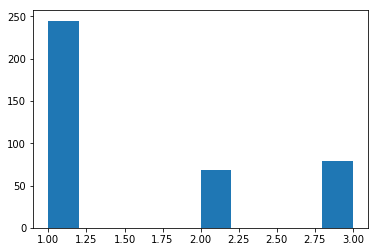

In [10]:
'''one hote encode origin column becuase is categorical and we dont want it to skew the modeling by being treated
as numeric'''

plt.hist(dataset.Origin) # three observations

In [13]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [14]:
origin = dataset.pop('Origin') # put column into a variable called origin and pop it from original data set

In [16]:
'''we know the data has three origins USE, Europe and Japan so append values one hot encoded'''

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


split the data into a training and test set

In [17]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [21]:
# check you have done it right

dataset.shape[0] == train_dataset.shape[0] + test_dataset.shape[0]

True

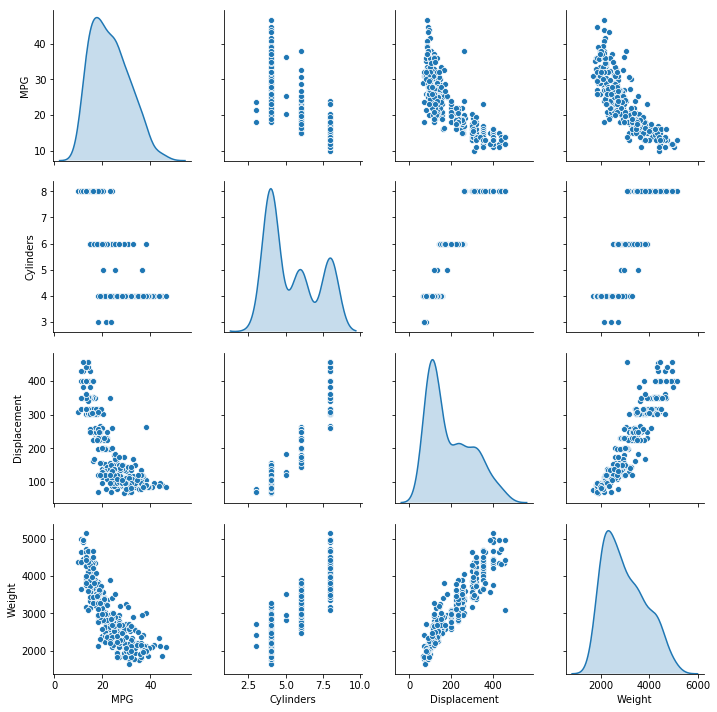

In [23]:
# plot the data

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

In [24]:
# correlation matrix

correlation_results = dataset.corr()

In [25]:
correlation_results

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
MPG,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,-0.565161,0.244313,0.451454
Cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,0.610494,-0.352324,-0.404209
Displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,0.655936,-0.371633,-0.440825
Horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,0.489625,-0.284948,-0.321936
Weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,0.600978,-0.293841,-0.447929
Acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,-0.258224,0.208298,0.115020
Model Year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,-0.136065,-0.037745,0.199841
USA,-0.565161,0.610494,0.655936,0.489625,0.600978,-0.258224,-0.136065,1.000000,-0.591434,-0.648583
Europe,0.244313,-0.352324,-0.371633,-0.284948,-0.293841,0.208298,-0.037745,-0.591434,1.000000,-0.230157
Japan,0.451454,-0.404209,-0.440825,-0.321936,-0.447929,0.115020,0.199841,-0.648583,-0.230157,1.000000


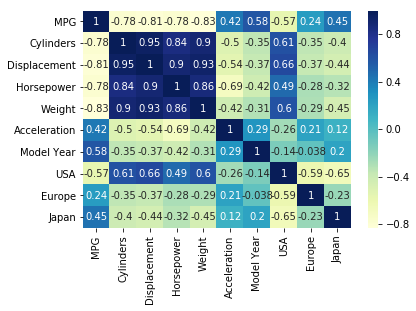

In [29]:
sns.heatmap(correlation_results, annot=True,cmap="YlGnBu")

the above shows that cylinders, displacement, horsepower are strongly negatively correlated with MPG. So higher of these values are associated with lower MPG, should be good predictors

In [30]:
# Split features form the label we are trying to predict MPG

train_labels = train_dataset.pop('MPG') # remember pop removes this label from the data set
test_labels = test_dataset.pop('MPG') 

Normalize the data? Check to see how the ranges differ for each of the features

In [32]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


why normalize? It is good practice to normalize features that use 
different scales and ranges. Although the model might converge without 
feature normalization, it makes training more difficult, 
and it makes the resulting model dependent on the choice of units 
used in the input

In [33]:
'''write a function to normalize the data ,make sure you base it on the training set, so test set (when normalized)
will have the distribution of the training projected onto the test set

function will be x - mean/std which is the z score'''

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Caution: The statistics used to normalize the inputs 
here (mean and standard deviation) need to be applied to any other data 
that is fed to the model, along with the one-hot encoding that we did 
earlier. That includes the test set as well as live data when the model 
is used in production.

In [37]:
normed_train_data.shape

(314, 9)

# Build the Tensorflow model

Since we are predicting a continuous variable MPG, we will used a Sequential model. The model will have two densely connected hidden layers and an output layer that returns a single continous value

In [38]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE)

In [39]:
# an empty model with the modeling steps built in
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [44]:
'''Now try out the model. Take a batch of 10 examples from the 
training data and call model.predict on it. Even though the model
is not trained yet, this just tests the output'''

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.21750256],
       [-0.3237394 ],
       [-0.25195813],
       [-0.30659395],
       [ 0.17038879],
       [-0.27012604],
       [ 0.19131228],
       [-0.15028985],
       [-0.219384  ],
       [-0.36731112]], dtype=float32)

In [49]:
# note we are normalizing the features not the dep var or label var

# Train the model

Train the model for 1000 epochs, and record the training and validation 
accuracy in the history object

In [50]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# model.fit(normalized_train_data,dep_var,...)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [51]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.118090,0.900620,2.118090,8.502602,2.310725,8.502603,995
996,2.033185,0.913436,2.033185,8.390145,2.332345,8.390145,996
997,2.165148,0.904257,2.165148,8.891314,2.408487,8.891315,997
998,1.961563,0.858964,1.961563,8.063079,2.275405,8.063079,998
999,2.223256,0.958718,2.223256,8.264495,2.301918,8.264495,999


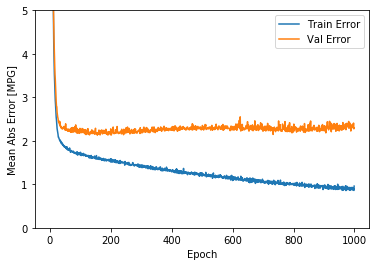

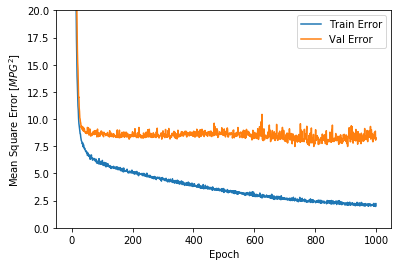

In [52]:
#  how many epochs? lets plot the history

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.


.........................................................................

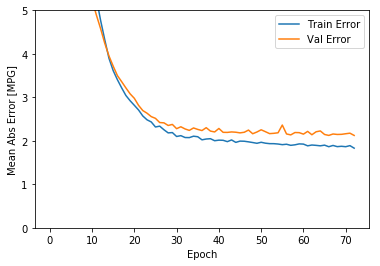

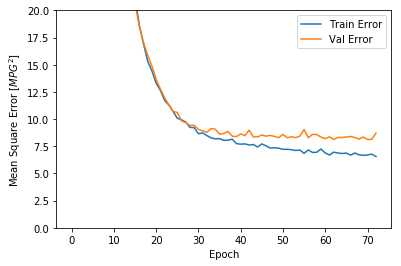

In [53]:
# remodel with less epochs, 100 is about right
# this code works it out

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [54]:
# use on the test data set

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.10 MPG


In [55]:
# predict model on test features and then you can compare to actual
test_predictions = model.predict(normed_test_data).flatten()

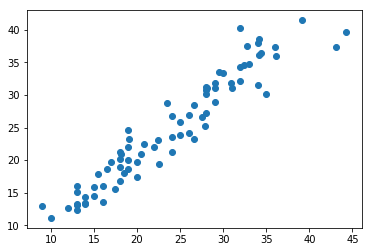

In [63]:
plt.scatter(test_labels, test_predictions)

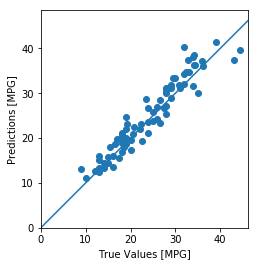

In [64]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

looks like the model does a good job as all the values sit on the line

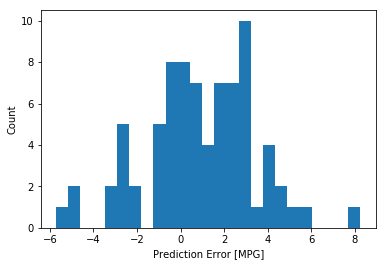

In [65]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [66]:
# we want the above to have a gaussian distribution

In [67]:
for i in range(10):
    print('hello world')

hello world
hello world
hello world
hello world
hello world
hello world
hello world
hello world
hello world
hello world
